# Head tilt maps computation and visualization
This notebook presents some code examples for generated head tilt maps as presented presented in Fayat et al., 2021.

Only a short downsampled data sequence is used here and parameters differ from the ones used for generating the figures of the paper. This notebook must be seen as an illustration of how such analysis can be performed to allow others to use the pipelines rather than code for replicating the exact panels of the paper.

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import angle_visualization
import angle_visualization.triangulation
from SphereProba.distributions import VonMisesFisher
import seaborn as sns
from madgwick import Madgwick
from angle_visualization.shapes import Sphere3D, Arrow3D
import warnings
# Import the helper functions
import sys
sys.path.append("..")
from imu_helpers.angle_helpers import get_angle
from imu_helpers import get_immobility

warnings.filterwarnings('ignore')  # Disable warnings
cmap = sns.mpl_palette("viridis", as_cmap=True)  # colormap for the histograms
SR = 100.  # sampling rate, in Herz

# Color cycler for the figures with x, y, z curves
rgb = ["#D55E00", "#009E73", "#0072B2"]
rgb_cycler = cycler(color=rgb)

# Column names for the data and computed features
col_acc = [f"a{ax}" for ax in "xyz"]  # imu accelerometer [G]
col_gyr = [f"g{ax}" for ax in "xyz"]  # imu gyroscope [deg/s]
col_gravity = [f"aG{ax}" for ax in "xyz"]  # imu gravitational acceleration [G]

In [2]:
# Load short example sequence
df = pd.read_csv("data/example_imu.csv", index_col=0)
df["time"] = np.arange(len(df)) / SR
# Compute gravity estimate from imu data using Madgwick filter
mf = Madgwick(acc=df[col_acc].values,
              gyr=np.radians(df[col_gyr].values),
              gain=.1,
              frequency=100.)
# Add the gravity estimate to the dataframe
rot = R.from_quat(mf.Q[:, [1, 2, 3, 0]]).inv()
df[col_gravity] = rot.apply(np.array([0, 0, 1]))

df.head(5)

,ax,ay,az,gx,gy,gz,time,aGx,aGy,aGz
counter,,,,,,,,,,
231915,-0.780623,0.437999,0.185337,-15.098572,56.335449,48.713684,0.00,-0.856256,0.479432,0.192278
231918,-0.938094,0.316661,0.160679,-7.804871,71.807861,14.656067,0.01,-0.863039,0.471965,0.180036
231921,-1.033064,0.278331,0.138218,8.094788,74.035645,-40.580750,0.02,-0.870638,0.461868,0.169312
231924,-1.116561,0.311534,0.161167,25.093079,55.175781,-60.539246,0.03,-0.875264,0.455806,0.161724
231927,-0.935652,0.460460,0.152867,16.517639,34.149170,-35.789490,0.04,-0.877698,0.452384,0.158100


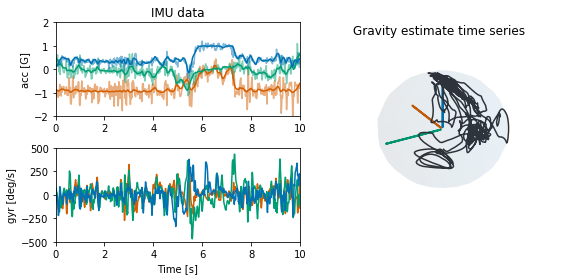

In [3]:
idx_end = 1000  # last idx to plot

fig = plt.figure(figsize=plt.figaspect(.5))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3, sharex=ax1)
ax3 = fig.add_subplot(1, 2, 2, projection="3d")

# Plot the accelerometer and gravity estimate values
ax1.set_prop_cycle(rgb_cycler)
ax1.plot(df[:idx_end].time,
         df[:idx_end][col_acc],
         alpha=.5)
ax1.plot(df[:idx_end].time,
         df[:idx_end][col_gravity])

# Plot the gyroscope data
ax2.set_prop_cycle(rgb_cycler)
ax2.plot(df[:idx_end].time, df[:idx_end][col_gyr])

# Plot the gravity estimate as a 3d time series
Sphere3D.add_sphere(ax=ax3, facecolor="grey", alpha=.05)
Arrow3D.add_xyz(ax=ax3, adjust_ax_lim=False, colors=rgb, lw=2)
ax3.plot(*df[col_gravity].values.T, c="#323034")

# Cosmetic changes
ax1.set_title("IMU data")
ax1.set_ylabel("acc [G]")
ax1.set_ylim([-2, 2.])
ax2.set_ylabel("gyr [deg/s]")
ax2.set_ylim([-500, 500])
ax2.set_xlabel("Time [s]")
ax2.set_xlim([0, idx_end / SR])
ax3.set_title("Gravity estimate time series")
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_zlim([-1, 1])

ax3.view_init(30, 150)
ax3.axis("off")
fig.tight_layout()

## Computing histograms on the triangulated sphere

In [4]:
def convert_to_logscale(counts, pad_value_zero=-1.):
    "Convert an array of counts by a max-normalized log scale with 0s replaced by a value."
    log_count = np.full(len(counts), pad_value_zero)
    log_max = np.log(counts[counts != 0]).max()
    log_count[counts != 0] = np.log(counts[counts != 0]) / log_max
    return log_count


# Compute the histogram on a triangulated sphere
n = 300  # Number of vertices for the Fibonacci sphere
d_sphere = angle_visualization.triangulation.Delaunay_Sphere(npoints=n)
_, count = d_sphere.spherical_histogram(df[col_gravity].values)

# Convert the resulting counts to a log colorscale 
count_log = convert_to_logscale(count)
colors = cmap(count_log)

## Visualization in 3d

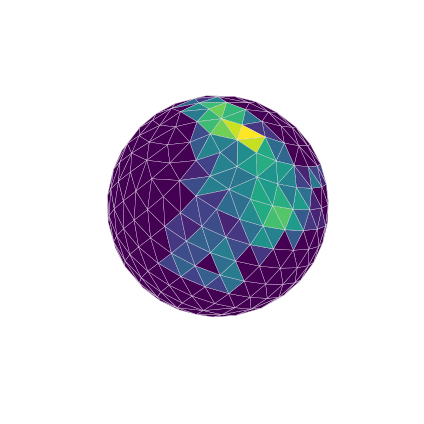

In [5]:
fig = plt.figure(figsize=plt.figaspect(1) * 1.5)
ax = fig.add_subplot(1, 1, 1, projection="3d")

# Plot the histogram on the sphere
angle_visualization.plot_faces(d_sphere.faces, ax=ax,
                               edge_colors="white",
                               face_colors=colors,
                               linewidth=.3,
                               alpha=1.)

# Additional rescalings / cosmetic changes
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(30, 150)
ax.axis("off")
fig.tight_layout()

## Visualization in 2d

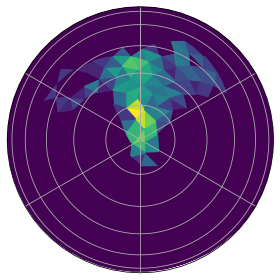

In [6]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection=angle_visualization.LAEA)

angle_visualization.fill_projected_faces_euclidean(
    *d_sphere.faces.transpose(2, 0, 1),
    face_colors=colors, ax=ax
)
ax.gridlines()
fig.tight_layout()

## Fit of a von Mises-Fisher on the histogram on the sphere

In [7]:
vmf = VonMisesFisher.fit(d_sphere.face_centroids, weights=count)
vmf

vMF distribution with parameters:
        μ = [-0.50098308 -0.00925751  0.86540756]
        κ = 11.378102612165453